In [1]:
from filterpy.kalman import KalmanFilter
tracker = KalmanFilter(dim_x=4, dim_z=2)

dt = 1.0

## Функцию перехода между состояниями.

Функция перехода между состояниями обозначенная как матрица F,
которую мы умножаем на предыдущее состояние нашей системы,
чтобы получить следующее состояние.

$$x = Fx$$

### Вектор состояния системы:

$$X_{k} =
\begin{bmatrix}
x\\ {x}'\\ y\\ {y}'
\end{bmatrix}
$$

### Составим уравнения перехода:

$$
x=1x+\Delta t{x}' + 0y + 0{y}'\\
v_{x} = 0x + 1{x}' + 0y + 0 {y}'\\
y = 0x + 0{x}' + 1y + \Delta t{y}'\\
v_{y} = 0x + 0{x}' + 0y + 1{y}'\\
$$

### Преобразуем в матрично-векторную форму:

$$
\begin{bmatrix}
x\\ {x}'\\ y\\  {y}'
\end{bmatrix} 
=
\begin{bmatrix}
1 & \Delta t & 0 & 0\\ 
0 & 1 & 0 & 0\\ 
0 & 0 & 1 & \Delta t\\ 
0 & 0 & 0 & 1
\end{bmatrix} 
\begin{bmatrix}
x\\ {x}'\\  y\\ {y}'
\end{bmatrix}
$$

### И получим матрицу эволюции системы:

$$
F_{k} =
\begin{bmatrix}
1 & \Delta t & 0 & 0\\ 
0 & 1 & 0 & 0\\ 
0 & 0 & 1 & \Delta t\\ 
0 & 0 & 0 & 1
\end{bmatrix}
$$

In [2]:
tracker.F = np.array([[1, dt, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, dt],
                      [0, 0, 0, 1]])

NameError: name 'np' is not defined

### Ковариационная матрица шума измерений:

$$ R_{k}=I\ast \sigma _{pos}^{2} $$

$$
R_{k} =
\begin{bmatrix}
\sigma _{pos}^{2} & 0 & 0 & 0\\ 
0 & \sigma _{pos}^{2} & 0 & 0\\ 
0 & 0 & \sigma _{pos}^{2} & 0\\ 
0 & 0 & 0 & \sigma _{pos}^{2}
\end{bmatrix}
$$

In [3]:
tracker.R = np.array([[10, 0, 0, 0],
                      [0, 10, 0, 0],
                      [0, 0, 10, 0],
                      [0, 0, 0, 10]])

NameError: name 'np' is not defined

### Ковариационная матрица шума процесса:

$$
Q_{k}=
\begin{bmatrix}
\sigma_{posX}^{2} & \sigma_{posX}\ast\sigma_{valX} & 0 & 0\\ 
0 & \sigma_{posX}^{2} & 0 & 0\\ 
0 & 0 & \sigma_{posY}^{2} & \sigma_{posY}\ast\sigma_{valY}\\ 
0 & 0 & 0 & \sigma_{posY}^{2}
\end{bmatrix}
$$

$$ \sigma _{val} = \sigma _{acc}\ast dt $$

$$ \sigma _{pos} = \frac{\sigma _{acc}\ast dt ^ 2}{2} $$

In [90]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
tracker.Q = block_diag(q, q)
print(tracker.Q)

[[0.00025 0.0005  0.      0.     ]
 [0.0005  0.001   0.      0.     ]
 [0.      0.      0.00025 0.0005 ]
 [0.      0.      0.0005  0.001  ]]


### Матрица управления


$$
B_{k}=
\begin{bmatrix}
\frac{dt^{2}}{2} & 0\\ 
0 & \frac{dt^{2}}{2}\\ 
dt & 0\\ 
0 & dt
\end{bmatrix}
$$

In [91]:
tracker.B = np.array([[(dt**2)/2, 0.],
                      [0,(dt**2)/2],
                      [dt, 0.],
                      [0., dt]])
print(tracker.B)

[[0.5 0. ]
 [0.  0.5]
 [1.  0. ]
 [0.  1. ]]


### Матрица измерений

$$ H_{k}=I $$

$$
H_{k}=
\begin{bmatrix}
1 & 0 & 0 & 0\\ 
0 & 1 & 0 & 0
\end{bmatrix}
$$

In [92]:
tracker.H = np.array([[1., 0., 0., 0.],
                      [0., 1., 0., 0.]])
print(tracker.H)

[[1 0 0 0]
 [0 1 0 0]]


## Вектор управления

$$ u_{k} = 
\begin{bmatrix}
{x}'' \\ 
{y}''
\end{bmatrix}
$$

In [111]:
tracker.u

0.0

## Реализация в коде

In [116]:
from filterpy.stats import plot_covariance_ellipse
from PosSensor import PosSensor
import plot_filter

R_std = 0.35
Q_std = 0.04

def tracker1():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    
    dt = 1.0 
    
    tracker.F = np.array([[1., dt, 0., 0.],
                          [0., 1., 0., 0.],
                          [0., 0., 1., dt],
                          [0., 0., 0., 1.]])   
    tracker.u = 0.
    tracker.H = np.array([[1., 0., 0., 0.],
                          [0., 1., 0., 0.]])
    
    tracker.R = np.array([[10., 0., 0., 0.],
                          [0., 10., 0., 0.],
                          [0., 0., 10., 0.],
                          [0., 0., 0., 10.]])
    
    q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
    tracker.Q = block_diag(q, q)
    tracker.x = np.array([[0, 0, 0, 0]]).T
    tracker.P = np.eye(4) * 10.
    return tracker

N = 30
sensor = PosSensor((0, 0), (2, .2), noise_std=R_std)
zs = np.array([sensor.read() for _ in range(N)])

robot_tracker = tracker1()
mu, cov, _, _ = robot_tracker.batch_filter(zs)

for x, P in zip(mu, cov):
    
    cov = np.array([[P[0, 0], P[2, 0]],
    [P[0, 2], P[2, 2]]])

    mean = (x[0, 0], x[2, 0])
    plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)
    

zs *= .3048
plot_filter(mu[:, 0], mu[:, 2])
plot_measurements(zs[:, 0], zs[:, 1])
plt.legend(loc=2)
plt.xlim(0, 20);    

ValueError: operands could not be broadcast together with shapes (2,2) (4,4) 

In [114]:
print(np.diag(robot_tracker.P))

[20.0004 10.0016 20.0004 10.0016]


[[20.0004 10.0008]
 [10.0008 10.0016]]


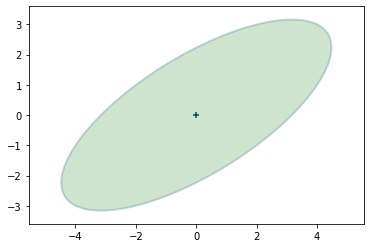

In [115]:
c = robot_tracker.P[0:2, 0:2]
print(c)
plot_covariance_ellipse((0, 0), cov=c, fc='g', alpha=0.2)

In [112]:
robot_tracker.P[2:4, 0:2]

array([[0., 0.],
       [0., 0.]])